# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>


  Pre-trained Model: AlexNet from PyTorch's models zoo.


  Grupo 43:

  Andrea M. Ruiz G. - A01794631

  Josías Ruiz P. - A00968460

  Saúl Y. Salgueiro L. - A0XXXXXXX

  Jesús Á. Salazar M. - A00513236

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [2]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [3]:
DATA_PATH = '/home/pepe/Documents/github_repos/datasets/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(254),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Use GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Show image sample

La imagen muestreada representa un: Cat


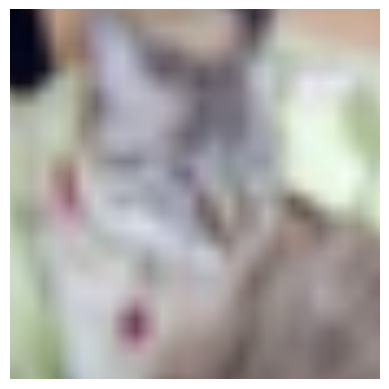

In [6]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Accuracy Function

In [7]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
      for (xi, yi) in loader:
        inputs= xi.to(device=device, dtype = torch.float32)
        targets = yi.to(device=device, dtype = torch.long)
        outputs = model(inputs)
        _, pred = outputs.max(dim=1)
        num_correct += (pred == targets).sum()
        num_total += pred.size(0)
      return float(num_correct)/num_total

### Load pre-trained model

In [8]:
model_alexNet = models.alexnet()

#### Model exploration

In [9]:
for i, w in enumerate(model_alexNet.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 11, 11]) True
1 torch.Size([64]) True
2 torch.Size([192, 64, 5, 5]) True
3 torch.Size([192]) True
4 torch.Size([384, 192, 3, 3]) True
5 torch.Size([384]) True
6 torch.Size([256, 384, 3, 3]) True
7 torch.Size([256]) True
8 torch.Size([256, 256, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([4096, 9216]) True
11 torch.Size([4096]) True
12 torch.Size([4096, 4096]) True
13 torch.Size([4096]) True
14 torch.Size([1000, 4096]) True
15 torch.Size([1000]) True


In [10]:
model_alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Model adjust

In [11]:
model_aux = nn.Sequential(*list(model_alexNet.children()))
model_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplac

In [12]:
model_aux = nn.Sequential(*list(model_alexNet.children())[:-1])

In [13]:
model_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [14]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [15]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False


### Training Loop

In [16]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            inputs = xi.to(device=device, dtype=torch.float32)
            targets = yi.to(device=device, dtype=torch.long)
            outputs = model(inputs)
            # cost = F.cross_entropy(input= scores, target=yi)
            loss_ = nn.CrossEntropyLoss()
            cost = loss_(outputs, targets)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')

In [17]:
lr = 5e-4
epochs = 10
num_classes = len(classes)
model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=256*6*6, out_features= 4096, bias= True), nn.ReLU(),
                       nn.Linear(in_features=4096, out_features= 1024, bias= True), nn.ReLU(),
                       nn.Linear(in_features=1024, out_features= num_classes, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [18]:
model1

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=9216, out_features=40

In [19]:

train(model1, optimiser, epochs)

Epoch: 0, costo: 2.152822256088257, accuracy: 0.4378,
Epoch: 1, costo: 1.681288480758667, accuracy: 0.4942,
Epoch: 2, costo: 1.938421368598938, accuracy: 0.4992,
Epoch: 3, costo: 1.4059619903564453, accuracy: 0.5438,
Epoch: 4, costo: 1.5935825109481812, accuracy: 0.5628,
Epoch: 5, costo: 0.8038739562034607, accuracy: 0.5908,
Epoch: 6, costo: 1.6681058406829834, accuracy: 0.568,
Epoch: 7, costo: 1.6666067838668823, accuracy: 0.5736,
Epoch: 8, costo: 1.0584548711776733, accuracy: 0.596,
Epoch: 9, costo: 0.7075225114822388, accuracy: 0.6182,


Evaluate the model on the test set

In [20]:
accuracy(model1, test_loader)

0.5915

We improve our results using Center crop transformation. It cropps an image by selecting a region around its center, removing the outer portions of the image.

We used AlexNet as the base architecture and add final classification layer to match the 10 classes in CIFAR-10. As we are trying to classificate images AlexNet could be a potencial candidate. AlexNet's connected layers have 4096 neurons each. Using this implementation we achieved a validation accuracy of 59.15%.

ResNet pre-trained model was more robust than AlexNet on CIFAR10 dataset, ResNet residual connections allow features to be captured and reused.

We experimented with the Adam and SDG optimizers, and were able to see better convergence with Adam as expected. Adam has ability to adapt the learning rate for each parameter during training in contrast to SDG.

Experimenting and monitoring we selected 10 epochs, when the training loss stops improving and the accuracy converges.